In [1]:
%pip install networkx   # les graphs
%pip install pandas    # les dataframes
%pip install pulp     # programmatoin lineaire

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import networkx as nx

# Utility modules
import os

## Test load a test

Graph with 4 nodes and 5 edges
{1: 0, 4: 1, 2: 2, 3: 2}


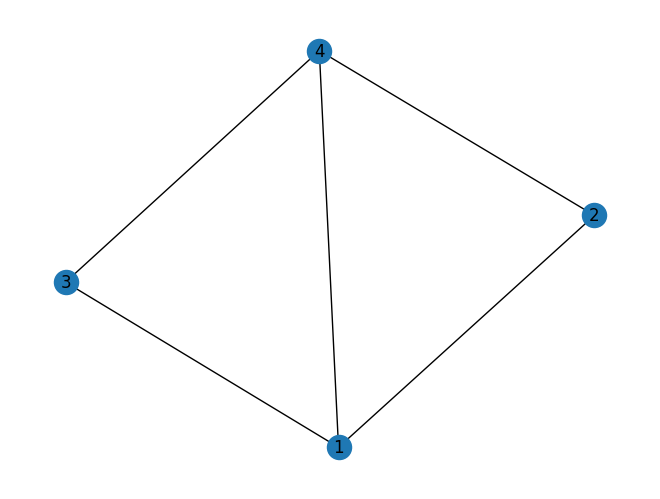

In [4]:
# Exemple de données
exams = [
    {"id": 1, "name": "Math", "students": [1, 2], "duration": 1},
    {"id": 2, "name": "Physics", "students": [1, 3], "duration": 2},
    {"id": 3, "name": "Chemistry", "students": [2], "duration": 1},
    {"id": 4, "name": "Biology", "students": [3, 2, 5], "duration": 2}
]

students = [
    {"id": 1, "name": "Justin", "promotion": 1},
    {"id": 2, "name": "Jessi", "promotion": 2},
    {"id": 3, "name": "August", "promotion": 2},
    {"id": 4, "name": "John", "promotion": 1},
    {"id": 5, "name": "Marie", "promotion": 1},
]

time_slots = [
    {"id": 0, "start": "2024-06-01 09:00", "end": "2024-06-01 11:00", "duration": 2},
    {"id": 1, "start": "2024-06-01 13:00", "end": "2024-06-01 15:00", "duration": 2}
]

rooms = [
    {"id": 1, "capacity": 5},
    {"id": 2, "capacity": 5},
]

def build_conflict_graph(exams):
    G = nx.Graph()
    for exam in exams:
        G.add_node(exam['id'], students=exam['students'], duration=exam['duration'])
    for i, exam1 in enumerate(exams):
        for j, exam2 in enumerate(exams):
            if i < j and set(exam1['students']).intersection(exam2['students']):
                G.add_edge(exam1['id'], exam2['id'])
    return G
def welsh_powell_coloring(G):
    coloring = {}
    nodes = sorted(G.nodes(), key=lambda x: len(list(G.neighbors(x))), reverse=True)
    available_colors = 0
    for node in nodes:
        neighbor_colors = {coloring[neighbor] for neighbor in G.neighbors(node) if neighbor in coloring}
        for color in range(available_colors):
            if color not in neighbor_colors:
                coloring[node] = color
                break
        else:
            coloring[node] = available_colors
            available_colors += 1
    return coloring
G = build_conflict_graph(exams)
coloring = welsh_powell_coloring(G)
print(G)
print(coloring)
nx.draw(G, with_labels=True)

### Test 2

# Welsh Powell avec optimisation avec recherche locale

In [5]:
import networkx as nx

# Construire le graph de conflits entre les examens
# Si deux examens partagent la même arête ils sont incompatibles
def build_conflict_graph(exams):
    G = nx.Graph()
    for exam in exams:
        G.add_node(exam['id'], students=exam['students'], duration=exam['duration'])
    for i, exam1 in enumerate(exams):
        for j, exam2 in enumerate(exams):
            if i < j and set(exam1['students']).intersection(exam2['students']):
                G.add_edge(exam1['id'], exam2['id'])
    return G


In [7]:
# Utiliser l'algorithme de Welsh-Powell pour ressortir une coloration du graphe
def welsh_powell_coloring(G):
    coloring = {}
    nodes = sorted(G.nodes(), key=lambda x: len(list(G.neighbors(x))), reverse=True)
    available_colors = 0
    for node in nodes:
        neighbor_colors = {coloring[neighbor] for neighbor in G.neighbors(node) if neighbor in coloring}
        for color in range(available_colors):
            if color not in neighbor_colors:
                coloring[node] = color
                break
        else:
            coloring[node] = available_colors
            available_colors += 1
    return coloring


In [8]:
# Assigner aux différentes salles les examens en prenant les capacités et les nombres d'étudiants en compte
# A la sortie nous avons une solution initiale réalisable
def assign_rooms_to_exams(coloring, exams, rooms, time_slots):
    schedule = {slot['id']: [] for slot in time_slots}
    penalty_schedule = []
    for exam_id, color in coloring.items():
        exam = next(exam for exam in exams if exam['id'] == exam_id)
        time_slot_id = time_slots[color]['id'] if color < len(time_slots) else 99
        room_assigned = False
        for room in rooms:
            if len(exam['students']) <= room['capacity']:
                schedule[time_slot_id].append({'exam': exam, 'room': room['id']})
                room_assigned = True if time_slot_id != 99 else False
                break
        if not room_assigned:
            penalty_schedule.append(exam_id)
    return schedule, penalty_schedule


In [97]:
schedule[1]

[{'exam': {'id': 1,
   'name': 'Exam 1',
   'students': [12,
    54,
    22,
    82,
    39,
    1,
    45,
    25,
    50,
    21,
    93,
    97,
    87,
    78,
    10,
    73,
    46,
    30,
    35,
    36,
    91,
    76,
    64,
    13],
   'duration': 3},
  'room': 2}]

# Fonctions de verification

In [9]:
# Fonction pour se rassurer qu'une programmation respecte les contraintes

# de capacites de salles
def check_room_capacities(schedule, rooms):
    """Return the amount of errors: number of students in a room > capacity"""
    errors = 0
    for time_slot_id, exam_room in schedule.items():
        room_students = dict()
        for item in exam_room:
            room_id = item['room']
            exam_students = len(item['exam']['students'])
            room_students[room_id] = room_students.get(room_id, 0) + exam_students
            if room_students[room_id] > next(room['capacity'] for room in rooms if room['id'] == room_id):
                errors += 1
    return errors

# de conflits d'etudiants
def check_exams_conflicts(schedule, exams):
    """Return the amount of errors: number of conflicting exams"""
    G = build_conflict_graph(exams)
    errors = 0
    for time_slot_id, item in schedule.items():
        if time_slot_id == 99:
            continue
        for i in range(len(item)):
            for j in range(i + 1, len(item)):
                exam1 = item[i]['exam']['id']
                exam2 = item[j]['exam']['id']
                if G.has_edge(exam1, exam2):
                    errors += 1
    return errors

In [10]:
# La fonction coût que l'on cherche à minimiser
# L'algorithme cherche à minimiser le nombre d'examens non programmés
def calculate_cost(schedule, penalty_schedule, penalty, exams, rooms):
    return len(penalty_schedule) * penalty + float("inf")*penalty*check_exams_conflicts(schedule, exams) + float("inf")*penalty*check_room_capacities(schedule, rooms)

In [11]:

# Fonction de recherche locale pour améliorer la solution initiale
# Elle essaie de trouver un meilleure solution, compare les coûts et garde la meilleure
def local_search_improvement(schedule, exams, rooms, time_slots, penalty_schedule, penalty):
    best_schedule = schedule.copy()
    best_penalty_schedule = penalty_schedule.copy()
    best_cost = calculate_cost(schedule, penalty_schedule, penalty, exams, rooms)
    
    for exam_id in penalty_schedule:
        exam = next(exam for exam in exams if exam['id'] == exam_id)
        for time_slot in time_slots:
            if time_slot['id'] == 99:
                continue
            for room in rooms:
                if room['capacity'] >= len(exam['students']):
                    new_schedule = {k: v.copy() for k, v in best_schedule.items()}
                    new_schedule[time_slot['id']].append({'exam': exam, 'room': room['id']})
                    # Enlève l'examen de la liste des examens non programmés
                    for schedule in new_schedule[99]:
                        if schedule['exam']['id'] == exam_id:
                            new_schedule[99].remove(schedule)
                    new_penalty_schedule = [e for e in best_penalty_schedule if e != exam_id]
                    new_cost = calculate_cost(new_schedule, new_penalty_schedule, penalty, exams, rooms)
                    # Vérifie si le nouveau coût est plus petit que le meilleur coût
                    if new_cost < best_cost:
                        best_schedule = new_schedule
                        best_penalty_schedule = new_penalty_schedule
                        best_cost = new_cost
    best_penalty_schedule = [sched["exam"]["id"] for sched in schedule.get(99, [])]
    return best_schedule, best_penalty_schedule


### Implémentation

In [12]:
def run1(exams, time_slots, rooms):
    # Construire le graphe des conflits
    G = build_conflict_graph(exams)

    # Appliquer l'algorithme de Welsh-Powell
    coloring = welsh_powell_coloring(G)
    print("Coloration: ", coloring, end="\n\n")

    utime_slots = time_slots if any(slot['id'] == 99 for slot in time_slots) else time_slots + [{"id": 99, "start": "non_programmé", "end": "non_programmé", "duration": float("inf")}]

    # Assigner les salles aux examens
    print("Assignation des salles et plages")
    schedule, penalty_schedule = assign_rooms_to_exams(coloring, exams, rooms, utime_slots)

    # Afficher le planning initial
    print("\nSchedule : ")
    print(*schedule.items(), sep="\n", end="\n\n")
    print(penalty_schedule, end="\n\n")

    # Améliorer la solution initiale par recherche locale
    improved_schedule, improved_penalty_schedule = local_search_improvement(schedule, exams, rooms, time_slots, penalty_schedule, 1000)
    print("Improved Schedule : ")
    print(*improved_schedule.items(), sep="\n", end="\n\n")


    # Afficher le planning amélioré
    for time_slot, scheduled_exams in improved_schedule.items():
        if time_slot == 99:
            print(f"Time Slot {time_slot} (non-programmed with penalty):")
            for item in scheduled_exams:
                print(f"\t{item['exam']['name']} is not scheduled.")
        else:
            print(f"Time Slot {time_slot}:")
            for item in scheduled_exams:
                exam = item['exam']
                room = item['room']
                print(f"\t{exam['name']} in Room {room}")

    total_penalty = calculate_cost(improved_schedule, improved_penalty_schedule, 1000, exams, rooms)
    print(f"Total penalty for non-programmed exams: {total_penalty}")
    print(check_room_capacities(improved_schedule, rooms))
    return schedule

schedule = run1(exams, time_slots, rooms)

Coloration:  {1: 0, 4: 1, 2: 2, 3: 2}

Assignation des salles et plages

Schedule : 
(0, [{'exam': {'id': 1, 'name': 'Math', 'students': [1, 2], 'duration': 1}, 'room': 1}])
(1, [{'exam': {'id': 4, 'name': 'Biology', 'students': [3, 2, 5], 'duration': 2}, 'room': 1}])
(99, [{'exam': {'id': 2, 'name': 'Physics', 'students': [1, 3], 'duration': 2}, 'room': 1}, {'exam': {'id': 3, 'name': 'Chemistry', 'students': [2], 'duration': 1}, 'room': 1}])

[2, 3]

Improved Schedule : 
(0, [{'exam': {'id': 1, 'name': 'Math', 'students': [1, 2], 'duration': 1}, 'room': 1}])
(1, [{'exam': {'id': 4, 'name': 'Biology', 'students': [3, 2, 5], 'duration': 2}, 'room': 1}])
(99, [{'exam': {'id': 2, 'name': 'Physics', 'students': [1, 3], 'duration': 2}, 'room': 1}, {'exam': {'id': 3, 'name': 'Chemistry', 'students': [2], 'duration': 1}, 'room': 1}])

Time Slot 0:
	Math in Room 1
Time Slot 1:
	Biology in Room 1
Time Slot 99 (non-programmed with penalty):
	Physics is not scheduled.
	Chemistry is not scheduled.

# Welsh Powel avec Recherche Taboo

In [13]:
import networkx as nx
import random

# Build the conflict graph
def build_conflict_graph(exams):
    G = nx.Graph()
    for exam in exams:
        G.add_node(exam['id'], students=exam['students'], duration=exam['duration'])
    for i, exam1 in enumerate(exams):
        for j, exam2 in enumerate(exams):
            # Placer une arrête entre deux examens s'il existe des étudiants entre eux.
            if i < j and set(exam1['students']).intersection(set(exam2['students'])):
                G.add_edge(exam1['id'], exam2['id'])
    return G

# Apply Welsh-Powell algorithm
def welsh_powell_coloring(G):
    coloring = {}
    nodes = sorted(G.nodes(), key=lambda x: len(list(G.neighbors(x))), reverse=True)
    available_colors = 0
    for node in nodes:
        neighbor_colors = {coloring[neighbor] for neighbor in G.neighbors(node) if neighbor in coloring}
        for color in range(available_colors):
            if color not in neighbor_colors:
                coloring[node] = color
                break
        else:
            coloring[node] = available_colors
            available_colors += 1
    return coloring

# Assign rooms to exams based on initial coloring
def tabu_assign_rooms_to_exams(coloring, exams, rooms, time_slots):
    schedule = {slot['id']: [] for slot in time_slots}
    penalty_schedule = []
    for exam_id, color in coloring.items():
        exam = next(exam for exam in exams if exam['id'] == exam_id)
        if color < len(time_slots):
            time_slot_id = time_slots[color]['id']
        else:
            time_slot_id = 99
        room_assigned = False
        for room in rooms:
            if len(exam['students']) <= room['capacity']:
                schedule[time_slot_id].append({'exam': exam, 'room': room['id']})
                room_assigned = True
                break
        if not room_assigned:
            penalty_schedule.append(exam_id)
    return schedule, penalty_schedule

# Cost function
def calculate_cost(schedule, penalty_schedule, penalty, exams, rooms):
    return len(penalty_schedule) * penalty + float("inf")*penalty*check_exams_conflicts(schedule, exams) + float("inf")*penalty*check_room_capacities(schedule, rooms)


In [14]:

# Tabu Search algorithm
def tabu_search(schedule, exams, rooms, time_slots, penalty_schedule, penalty, max_iterations=100, tabu_tenure=5):
    best_schedule = schedule.copy()
    best_penalty_schedule = penalty_schedule.copy()
    best_cost = calculate_cost(schedule, penalty_schedule, penalty, exams, rooms)
    
    tabu_list = []
    
    for iteration in range(max_iterations):
        neighborhood = []

        # Generate neighborhood solutions by trying to reschedule unscheduled exams
        for exam_id in penalty_schedule:
            exam = next(exam for exam in exams if exam['id'] == exam_id)
            for time_slot in time_slots:
                if time_slot['id'] == 99:
                    continue
                for room in rooms:
                    if room['capacity'] >= len(exam['students']):
                        new_schedule = {k: v.copy() for k, v in best_schedule.items()}
                        if time_slot['id'] not in new_schedule:
                            new_schedule[time_slot['id']] = []
                        new_schedule[time_slot['id']].append({'exam': exam, 'room': room['id']})
                        new_penalty_schedule = [e for e in best_penalty_schedule if e != exam_id]
                        new_cost = calculate_cost(new_schedule, new_penalty_schedule, penalty, exams, rooms)
                        neighborhood.append((new_schedule, new_penalty_schedule, new_cost, (exam_id, time_slot['id'], room['id'])))
        
        # Select the best neighbor solution not in tabu list
        neighborhood = sorted(neighborhood, key=lambda x: x[2])
        for neighbor in neighborhood:
            if neighbor[3] not in tabu_list:
                best_schedule, best_penalty_schedule, best_cost = neighbor[0], neighbor[1], neighbor[2]
                tabu_list.append(neighbor[3])
                if len(tabu_list) > tabu_tenure:
                    tabu_list.pop(0)
                break
    best_penalty_schedule = [sched["exam"]["id"] for sched in best_schedule.get(99, [])]
    return best_schedule, best_penalty_schedule

def run_tabu_method(exams, time_slots, rooms):
    # Initial setup
    G = build_conflict_graph(exams)
    coloring = welsh_powell_coloring(G)
    utime_slots = time_slots if any(slot["id"] for slot in time_slots if slot["id"]==99) else [{"id": 99, "start": "non_programmed", "end": "non_programmed", "duration": float("inf")}] + time_slots
    schedule, penalty_schedule = tabu_assign_rooms_to_exams(coloring, exams, rooms, utime_slots)
    print(*schedule.items(), sep="\n", end="\n\n")
    # Apply Tabu Search to improve the schedule
    improved_schedule, improved_penalty_schedule = tabu_search(schedule, exams, rooms, time_slots, penalty_schedule, 1000)
    print(improved_schedule)

    # Display the improved schedule
    for time_slot, scheduled_exams in improved_schedule.items():
        if time_slot == 99:
            print(f"Time Slot {time_slot} (non-programmed with penalty):")
            for exam_id in improved_penalty_schedule:
                print(f"  Exam {exams[exam_id - 1]['name']} is not scheduled.")
        else:
            print(f"Time Slot {time_slot}:")
            for item in scheduled_exams:
                exam = item['exam']
                room = item['room']
                print(f"  Exam {exam['name']} in Room {room}")

    total_penalty = calculate_cost(improved_schedule, improved_penalty_schedule, 1000, exams, rooms)
    print(f"Total penalty for non-programmed exams: {total_penalty}")

run_tabu_method(exams, time_slots, rooms)

(99, [{'exam': {'id': 1, 'name': 'Math', 'students': [1, 2], 'duration': 1}, 'room': 1}])
(0, [{'exam': {'id': 4, 'name': 'Biology', 'students': [3, 2, 5], 'duration': 2}, 'room': 1}])
(1, [{'exam': {'id': 2, 'name': 'Physics', 'students': [1, 3], 'duration': 2}, 'room': 1}, {'exam': {'id': 3, 'name': 'Chemistry', 'students': [2], 'duration': 1}, 'room': 1}])

{99: [{'exam': {'id': 1, 'name': 'Math', 'students': [1, 2], 'duration': 1}, 'room': 1}], 0: [{'exam': {'id': 4, 'name': 'Biology', 'students': [3, 2, 5], 'duration': 2}, 'room': 1}], 1: [{'exam': {'id': 2, 'name': 'Physics', 'students': [1, 3], 'duration': 2}, 'room': 1}, {'exam': {'id': 3, 'name': 'Chemistry', 'students': [2], 'duration': 1}, 'room': 1}]}
Time Slot 99 (non-programmed with penalty):
  Exam Math is not scheduled.
Time Slot 0:
  Exam Biology in Room 1
Time Slot 1:
  Exam Physics in Room 1
  Exam Chemistry in Room 1
Total penalty for non-programmed exams: nan


# 3. En utilisant la programmation linéaire en nombre entier

Le programme linéaire va optimiser les contraintes molles et s'assurer que les contraintes durs soient remplies.

Une pénalité est rajoutée à la fonction objectif dans le cas où l'algorithme décide de ne pas programmer un examen. Elle le fera donc si elle n'a pas pu converger vers une solution réalisable au programme étant donné les contraintes de non-conflits entre les examens d'un étudiant. 

Le programme linéaire peut être formulé mathématiquement, et sa formulation, bien qu'eshaustive peut être fournise.

In [15]:
# Bibliothèque pour la Programmation Linéaire en nombres entiers
%pip install pulp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import pulp

# Modèle des données

# Examen
exams = [
            {"id": 1, "name": "Math", "students": [1, 2, 3], "duration": 2},
            {"id": 2, "name": "Physics", "students": [1, 3, 4], "duration": 1},
            {"id": 3, "name": "Chemistry", "students": [2, 4, 5], "duration": 2},
            {"id": 4, "name": "Biology", "students": [1, 2, 5], "duration": 1},
            {"id": 5, "name": "History", "students": [3, 4, 5], "duration": 1}
        ]

# Etudiant
students = [
    {"id": 1, "name": "Justin", "promotion": 1},
    {"id": 2, "name": "Jessi", "promotion": 2},
    {"id": 3, "name": "August", "promotion": 2},
    {"id": 4, "name": "John", "promotion": 1},
    {"id": 5, "name": "Marie", "promotion": 1},
    {"id": 6, "name": "Jane", "promotion": 2},
]

# Id des étudiants : L'algorithme n'a pas besoin d'informations personnelles sur les étudiants
students_id = [s["id"] for s in students]

# Plages disponibles
time_slots = [
    {"id": 1, "start": "2024-06-01 09:00", "end": "2024-06-01 11:00", "duration": 2},
    {"id": 2, "start": "2024-06-01 13:00", "end": "2024-06-01 15:00", "duration": 2}
]

# Salle de classe
rooms = [
    {"id": 1, "capacity": 5},
    {"id": 2, "capacity": 5},
]


In [17]:

# Designation : salle-plage
room_slot = dict()
slot_to_time = dict()
idDesignation = 1
for room in rooms:
    for time_period in time_slots:
        room_slot[idDesignation] = (room["id"], time_period["id"])
        slot_to_time[idDesignation] = time_period["id"]
        idDesignation += 1

# Penalty when not programmed
penalty = 1000

# Variables
exam_ids = [exam["id"] for exam in exams]
slot_ids = list(room_slot.keys())
stud_ids = students_id = [s["id"] for s in students]
room_ids = [room["id"] for room in rooms]

# Variables de décision du programme linéaire
# Chaque variable associe un examen, une salle et une plage horaire à 1 si l'examen est programmé à cet endroit et 0 sinon
x = pulp.LpVariable.dicts("Examen_dans_la_plage", [(i, k) for i in exam_ids for k in slot_ids], 0, 1, pulp.LpBinary)
x_non_programmed = pulp.LpVariable.dicts("exam_non_programmed", exam_ids, 0, 1, pulp.LpBinary)

# Variables de charge de travail pour chaque étudiant et chaque créneau horaire
W = pulp.LpVariable.dicts("workload", [(sid, t) for sid in stud_ids for t in slot_ids], 0, None, pulp.LpContinuous)
M = pulp.LpVariable.dicts("max_workload", stud_ids, 0, None, pulp.LpContinuous)
m = pulp.LpVariable.dicts("min_workload", stud_ids, 0, None, pulp.LpContinuous)

# Définition du Problème de minimisation
prob = pulp.LpProblem("Programmation_d_examens", pulp.LpMinimize)

# Définiation des contraintes
# Contraintes : chaque examen doit être assigné à un créneau horaire ou à la plage "non_programmée"
for i in exam_ids:
    prob += pulp.lpSum(x[i, k] for k in slot_ids) + x_non_programmed[i] == 1

# Contraintes : pas de conflits pour les étudiants et calcul de la charge pour chaque étudiant
for student in students_id:
    exams_for_student = [exam["id"] for exam in exams if student in exam["students"]]
    for t in time_slots:
        prob += pulp.lpSum(x[i, k] for i in exams_for_student for k in slot_ids if slot_to_time[k] == t["id"]) <= 1  # S'assure qu'il n'y a pas de conflits
        prob += W[student, t["id"]] == pulp.lpSum(x[i, k] for i in exams_for_student for k in slot_ids if slot_to_time[k] == t["id"])  # Calcule la charge de travail pour chaque étudiant et un créneau horaire dans une salle

# Contraintes : capacités des salles
for t in slot_ids:
    room_id = room_slot[t][0]
    room_capacity = next(room for room in rooms if room["id"] == room_id)["capacity"]
    prob += pulp.lpSum(x[i, t] * len(exam["students"]) for i, exam in enumerate(exams, start=1)) <= room_capacity

# Contraintes : Durée des examens
for exam in exams:
    for t in slot_ids:
        time_slot_id = room_slot[t][1]
        duration = next(ts for ts in time_slots if ts["id"] == time_slot_id)["duration"]
        if exam["duration"] > duration:
            prob += x[exam["id"], t] == 0  # Make impossible to program an exam

# Contraintes pour les charges de travail minimales et maximales
for s in students_id:
    for t in time_slots:
        prob += M[s] >= W[s, t["id"]]  # Charge de travail maximale
        prob += m[s] <= W[s, t["id"]]  # Charge de travail minimale

# Fonction objectif : minimiser le déséquilibre total des examens et la pénalisation des examens non programmés
prob += pulp.lpSum(M[s] - m[s] for s in students_id) + penalty * pulp.lpSum(x_non_programmed[i] for i in exam_ids)

# Résolution
prob.solve()

# Affichage des résultats
for i in exam_ids:
    for k in slot_ids:
        if pulp.value(x[i, k]) == 1:
            print(f"Examen {i} est planifié dans la salle {room_slot[k][0]} et le créneau {room_slot[k][1]}")
    if pulp.value(x_non_programmed[i]) == 1:
        print(f"Examen {i} est planifié dans la plage non_programmée avec pénalité")

# Affichage du déséquilibre
for s in students_id:
    print(f"Déséquilibre pour l'étudiant {s}: {pulp.value(M[s]) - pulp.value(m[s])}")


Examen 1 est planifié dans la plage non_programmée avec pénalité
Examen 2 est planifié dans la salle 2 et le créneau 2
Examen 3 est planifié dans la plage non_programmée avec pénalité
Examen 4 est planifié dans la plage non_programmée avec pénalité
Examen 5 est planifié dans la salle 2 et le créneau 1
Déséquilibre pour l'étudiant 1: 1.0
Déséquilibre pour l'étudiant 2: 0.0
Déséquilibre pour l'étudiant 3: 0.0
Déséquilibre pour l'étudiant 4: 0.0
Déséquilibre pour l'étudiant 5: 1.0
Déséquilibre pour l'étudiant 6: 0.0


In [18]:
import random

# Generate exam data
exams = []
for i in range(1, 21):
    exam = {
        "id": i,
        "name": f"Exam {i}",
        "students": random.sample(range(1, 51), random.randint(10, 30)),
        "duration": random.randint(1, 3)
    }
    exams.append(exam)

# Generate student data
students = []
for i in range(1, 51):
    student = {
        "id": i,
        "name": f"Student {i}",
        "promotion": random.randint(1, 4)
    }
    students.append(student)

# Generate room data
rooms = []
for i in range(1, 11):
    room = {
        "id": i,
        "capacity": random.randint(10, 30)
    }
    rooms.append(room)

# Generate time slot data
time_slots = []
for i in range(1, 5):
    time_slot = {
        "id": i,
        "start": f"2022-01-01 {random.randint(8, 16)}:00",
        "end": f"2022-01-01 {random.randint(17, 23)}:00",
        "duration": random.randint(1, 4)
    }
    time_slots.append(time_slot)

# Print the generated data
print("Exams:")
for exam in exams:
    print(exam)
print("\nStudents:")
for student in students:
    print(student)
print("\nRooms:")
for room in rooms:
    print(room)
print("\nTime Slots:")
for time_slot in time_slots:
    print(time_slot)


Exams:
{'id': 1, 'name': 'Exam 1', 'students': [35, 20, 8, 42, 48, 23, 44, 14, 12, 10, 45, 36], 'duration': 1}
{'id': 2, 'name': 'Exam 2', 'students': [38, 32, 24, 3, 46, 39, 33, 5, 14, 26, 28, 23, 34, 36, 12, 17, 31, 19, 6], 'duration': 2}
{'id': 3, 'name': 'Exam 3', 'students': [25, 13, 7, 27, 50, 37, 21, 10, 49, 6, 14, 22, 23, 11, 4, 31, 20, 18, 9, 48, 24, 15, 47, 40, 5, 2, 36, 19], 'duration': 1}
{'id': 4, 'name': 'Exam 4', 'students': [7, 24, 49, 23, 27, 6, 38, 41, 21, 32, 25, 11, 31, 39], 'duration': 3}
{'id': 5, 'name': 'Exam 5', 'students': [16, 3, 46, 4, 34, 36, 50, 15, 31, 21, 28, 41, 42, 35, 2, 10, 40, 27, 25, 43, 24, 45, 26, 17, 5, 33], 'duration': 2}
{'id': 6, 'name': 'Exam 6', 'students': [36, 30, 11, 31, 39, 44, 3, 8, 23, 37, 24, 4, 43, 38, 41, 25, 22, 47, 32, 29, 19, 34, 17, 2, 10, 27, 26, 35, 49, 14], 'duration': 3}
{'id': 7, 'name': 'Exam 7', 'students': [13, 37, 20, 27, 8, 2, 32, 40, 14, 16, 36, 12, 47, 41, 43, 46, 38, 15, 6, 39, 24, 28, 30, 17, 29, 5, 49], 'duration

# Create a test case

In [19]:
import random
random.sample(range(10), 4)

[1, 8, 7, 2]

In [20]:
def create_test_case(number_of_exams = 3, number_of_students = 5, number_of_rooms = 3, number_of_time_slots = 3):
    import random
    
    # Generate exam data
    exams = []
    for i in range(1, number_of_exams + 1):
        exam = {
            "id": i,
            "name": f"Exam {i}",
            "students": random.sample(range(1, number_of_students + 1), random.randint(10, 30)),
            "duration": random.randint(1, 3)
        }
        exams.append(exam)

    # Generate student data
    students = []
    for i in range(1, number_of_students + 1):
        student = {
            "id": i,
            "name": f"Student {i}",
            "promotion": random.randint(1, 4)
        }
        students.append(student)

    # Generate room data
    rooms = []
    for i in range(1, number_of_rooms + 1):
        room = {
            "id": i,
            "capacity": random.randint(10, 30)
        }
        rooms.append(room)

    # Generate time slot data
    time_slots = []
    for i in range(1, number_of_time_slots + 1):
        time_slot = {
            "id": i,
            "start": f"2022-01-01 {random.randint(8, 16)}:00",
            "end": f"2022-01-01 {random.randint(17, 23)}:00",
            "duration": random.randint(1, 4)
        }
        time_slots.append(time_slot)
    
    return exams, students, rooms, time_slots

create_test_case(20, 50, 10, 4)

([{'id': 1,
   'name': 'Exam 1',
   'students': [34, 13, 17, 5, 38, 37, 50, 43, 41, 39, 33],
   'duration': 3},
  {'id': 2,
   'name': 'Exam 2',
   'students': [20,
    46,
    6,
    24,
    48,
    12,
    49,
    21,
    14,
    35,
    16,
    7,
    31,
    38,
    25,
    33,
    3,
    29,
    13,
    9,
    8,
    39,
    18,
    34,
    32,
    42,
    26,
    28,
    37,
    4],
   'duration': 2},
  {'id': 3,
   'name': 'Exam 3',
   'students': [5,
    45,
    38,
    33,
    8,
    22,
    12,
    37,
    29,
    30,
    34,
    35,
    44,
    20,
    31,
    28,
    18,
    1,
    26,
    4,
    17,
    21,
    42,
    7,
    10],
   'duration': 1},
  {'id': 4,
   'name': 'Exam 4',
   'students': [5, 46, 27, 13, 25, 50, 34, 6, 17, 7, 43, 3, 8, 40, 41, 47],
   'duration': 1},
  {'id': 5,
   'name': 'Exam 5',
   'students': [40,
    2,
    14,
    4,
    30,
    18,
    38,
    13,
    27,
    24,
    16,
    34,
    19,
    46,
    5,
    21,
    15,
    17,
    8,
    3,
 

# Saving Tests

In [21]:
import os

# Save the data in a folder
def save_test(folder_path, exams, students, time_slots, rooms):
    if not os.path.exists(folder_path):
        # Create target Directory
        os.mkdir(folder_path)
        print("Directory ", folder_path, " Created ")
    # save all the data
    pd.DataFrame(exams).to_csv(folder_path + "/exams.csv", index=False)
    pd.DataFrame(students).to_csv(folder_path + "/students.csv", index=False)
    pd.DataFrame(time_slots).to_csv(folder_path + "/time_slots.csv", index=False)
    pd.DataFrame(rooms).to_csv(folder_path + "/rooms.csv", index=False)
    print("All files saved in ", folder_path)

In [22]:
def load_test(folder_path):
    exams = pd.read_csv(folder_path + "/exams.csv").to_dict(orient="records")
    students = pd.read_csv(folder_path + "/students.csv").to_dict(orient="records")
    time_slots = pd.read_csv(folder_path + "/time_slots.csv").to_dict(orient="records")
    rooms = pd.read_csv(folder_path + "/rooms.csv").to_dict(orient="records")
    # Generate room_slots
    room_slots = {}
    idDesignation = 1
    for room in rooms:
        for time_slot in time_slots:
            room_slots[idDesignation] = (room["id"], time_slot["id"])
            idDesignation += 1
    return exams, students, time_slots, rooms, room_slots

### Implementation

In [29]:
def create_test_case(number_of_exams = 3, number_of_students = 5, number_of_rooms = 3, number_of_time_slots = 3):
    import random
    
    # Generate exam data
    exams = []
    for i in range(1, number_of_exams + 1):
        exam = {
            "id": i,
            "name": f"Exam {i}",
            "students": random.sample(range(1, number_of_students + 1), random.randint(10, 30)),
            "duration": random.randint(1, 3)
        }
        exams.append(exam)
    
    # Define room_slots
    room_slots = {}
    
    # Return the necessary variables
    return exams, students, rooms, time_slots, room_slots

# Create the test case
exams, students, rooms, time_slots, room_slots = create_test_case(50, 100, 20, 5)

In [30]:
load_test("test2")

([{'id': 1,
   'name': 'Exam 1',
   'students': '[32, 36, 39, 20, 83, 81, 25, 41, 96, 76, 80, 33, 27, 31, 88, 86, 44, 34, 72]',
   'duration': 2},
  {'id': 2,
   'name': 'Exam 2',
   'students': '[67, 38, 29, 93, 92, 9, 43, 78, 58, 12, 77, 81, 24, 27, 71, 15, 80, 47, 74, 72]',
   'duration': 1},
  {'id': 3,
   'name': 'Exam 3',
   'students': '[11, 69, 7, 19, 78, 52, 49, 10, 73, 26, 66, 94, 71, 100, 91, 2, 51, 37, 5, 27, 18, 34, 96, 45, 89, 99, 13, 1, 98, 31]',
   'duration': 1},
  {'id': 4,
   'name': 'Exam 4',
   'students': '[24, 64, 96, 89, 71, 54, 79, 7, 22, 8, 82, 85, 41, 37, 35, 97, 21, 73, 66, 67, 94, 4, 50, 83, 29, 69, 10]',
   'duration': 1},
  {'id': 5,
   'name': 'Exam 5',
   'students': '[4, 74, 44, 95, 72, 25, 12, 21, 88, 98, 49, 46, 1, 91, 71, 8, 7, 36, 65, 60, 10, 51, 39, 61, 73, 85, 86, 83, 28]',
   'duration': 2},
  {'id': 6,
   'name': 'Exam 6',
   'students': '[53, 21, 73, 70, 27, 3, 44, 13, 36, 69, 94, 29, 37, 6, 16]',
   'duration': 2},
  {'id': 7,
   'name': 'Exa

In [31]:
# Save the test case
save_test("test1", exams, students, time_slots, rooms)

All files saved in  test1


In [32]:
exams, students, time_slots, rooms, room_slots = load_test("test2")

In [33]:
room_slots

{1: (1, 1),
 2: (1, 2),
 3: (1, 3),
 4: (1, 4),
 5: (1, 5),
 6: (2, 1),
 7: (2, 2),
 8: (2, 3),
 9: (2, 4),
 10: (2, 5),
 11: (3, 1),
 12: (3, 2),
 13: (3, 3),
 14: (3, 4),
 15: (3, 5),
 16: (4, 1),
 17: (4, 2),
 18: (4, 3),
 19: (4, 4),
 20: (4, 5),
 21: (5, 1),
 22: (5, 2),
 23: (5, 3),
 24: (5, 4),
 25: (5, 5),
 26: (6, 1),
 27: (6, 2),
 28: (6, 3),
 29: (6, 4),
 30: (6, 5),
 31: (7, 1),
 32: (7, 2),
 33: (7, 3),
 34: (7, 4),
 35: (7, 5),
 36: (8, 1),
 37: (8, 2),
 38: (8, 3),
 39: (8, 4),
 40: (8, 5),
 41: (9, 1),
 42: (9, 2),
 43: (9, 3),
 44: (9, 4),
 45: (9, 5),
 46: (10, 1),
 47: (10, 2),
 48: (10, 3),
 49: (10, 4),
 50: (10, 5),
 51: (11, 1),
 52: (11, 2),
 53: (11, 3),
 54: (11, 4),
 55: (11, 5),
 56: (12, 1),
 57: (12, 2),
 58: (12, 3),
 59: (12, 4),
 60: (12, 5),
 61: (13, 1),
 62: (13, 2),
 63: (13, 3),
 64: (13, 4),
 65: (13, 5),
 66: (14, 1),
 67: (14, 2),
 68: (14, 3),
 69: (14, 4),
 70: (14, 5),
 71: (15, 1),
 72: (15, 2),
 73: (15, 3),
 74: (15, 4),
 75: (15, 5),
 76:

In [34]:
def txt_to_list(txt):
    txt = txt[1:-1]
    return [int(nbr.strip()) for nbr in txt.split(",") ]

txt_to_list('[1, 2]')

[1, 2]

In [35]:
from utils import *

exams, students, time_slots, rooms, room_slots = load_test("test2")